Компания "StreamChic" хочет выявить характеристики наиболее популярных игр для проведения рекламной компании на следующий год.

## Изучение общей информации предоставленного датасета

Загружаю датасет и необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

df = pd.read_csv('/datasets/games.csv')
display(df.head())
df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Таблица выглядит красиво. Обращают на себя внимание пропуски в Critic_Score , User_Score & Rating (много пропусков). Единичные пропуски в Name, Genre, не всё заполнено в Year_of_Release.
Имеем 16715 строк и 11 столбцов.
Основные рынки С.Америка, Европа и Япония + остальные.

## Подготовка данных

### Приведение к нижнему регистру названий столбцов

In [2]:
df.columns = df.columns.str.lower()

### Преобразование типа данных

Преобразую дату релиза в datetime.
Предварительно смотрю на top-10 (как наиболее значимые) по продажам в NA без даты релиза.

In [3]:
df.loc[df['year_of_release'].isna()].sort_values(by='na_sales', ascending=False).head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T
1506,Adventure,2600,NaN,Adventure,1.21,0.08,0.00,0.01,NaN,NaN,NaN
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T


In [4]:
df['year_of_release'].min()

1980.0

В списке присутствуют как древние, так и новые платформы. Заменю пропущенные значения на 1979 (раньше начала, для удобства отслеживания).

In [5]:
df['year_of_release'] = df['year_of_release'].fillna(1979)
df['year_of_release'] = df['year_of_release'].astype('int')

Преобразую дату релиза в datetime.

In [6]:
df['year_of_release'] = pd.to_datetime(df['year_of_release'], format='%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null datetime64[ns]
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 1.4+ MB


Значения в sales трогать не буду, т.к. измерения производятся в млн. копий.

А вот critic_score и user_score измеряются по 100 и 10-бальной шкале соответственно с одним знаком после запятой, поэтому логично поменять на float в user_score.

In [7]:
df['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
2.3       2
0.7       2
1         2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

Аббревиатура tbd обозначает, что рейтинг еще не определен, в процессе. Её смело можно рассматривать как пропущенное значение.

In [8]:
df.loc[df['user_score'] == 'tbd'
       , 'user_score'] = np.nan

In [9]:
df['user_score'] = pd.to_numeric(df['user_score'])

In [10]:
display(df['user_score'].min())
display(df['user_score'].max())

0.0

9.7

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null datetime64[ns]
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 1.4+ MB


### Обработка пропусков

Смотрю на процент пропущенных пропусков.

In [12]:
df.isnull().sum().sort_values(ascending=False)/len(df)*100

user_score         54.591684
critic_score       51.319174
rating             40.478612
genre               0.011965
name                0.011965
other_sales         0.000000
jp_sales            0.000000
eu_sales            0.000000
na_sales            0.000000
year_of_release     0.000000
platform            0.000000
dtype: float64

Для начала разберусь с пропусками в названии игры, всего два значения.

In [13]:
display(df.loc[df['name'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993-01-01,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993-01-01,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Две игры 1993 года на платформе GEN - незначительно, однако продано 2,4 млн. копий (а это много, тем более для 1993 года). Как видно, здесь же и два пропущенных значения в жанре. Переименую в another.

In [14]:
df.loc[df['name'].isna(), 'name'] = 'another'

In [15]:
df.loc[df['genre'].isna(), 'genre'] = 'another'

Пропуски в рейтинге критиков и пользователей заполнять не буду, т.к. это может значительно сдвинуть результаты исследования (много пропусков).

А вот пропуски возрастного рейтинга меняю на значения вне рейтинга "out_rang", так как переменная категориальная.

In [16]:
df.loc[df['rating'].isna(), 'rating'] = 'out_rang'

### Суммарные продажи

Посчитаю суммарные продажи.

In [17]:
df['all_sales'] = df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

In [18]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,NaN,NaN,out_rang,40.24
2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,out_rang,31.38


## Исследовательский анализ данных

### Распределение релизов игр по годам

In [19]:
sales_by_year = df.pivot_table(index='year_of_release'
                               , values=['name', 'all_sales']
                               , aggfunc={'name':'count', 'all_sales':'sum'})

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


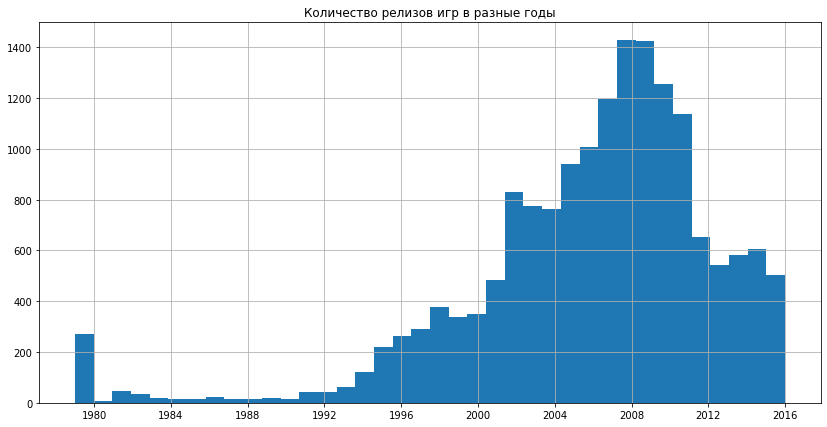

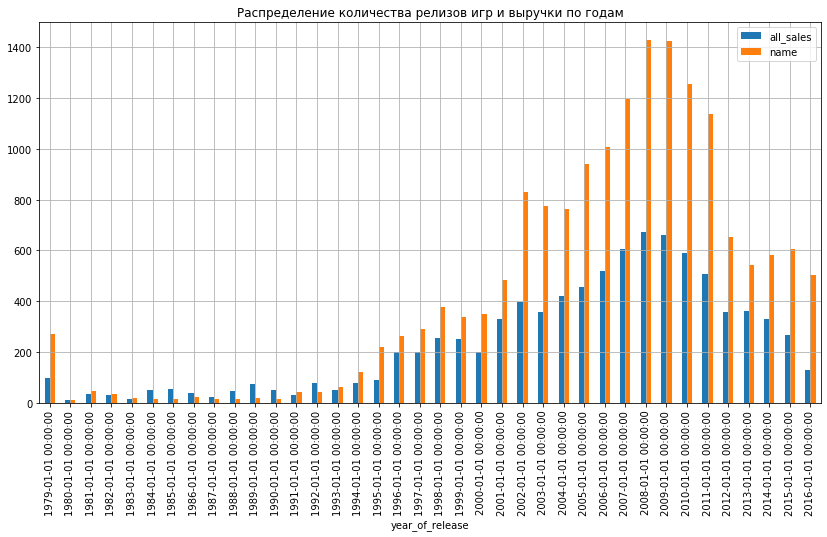

In [20]:
df['year_of_release'].hist(bins=38, figsize=(14,7))
plt.title('Количество релизов игр в разные годы')

sales_by_year.plot.bar(figsize=(14,7), grid=True)
plt.title('Распределение количества релизов игр и выручки по годам')
plt.show()

Как видно, с 1993 г. отмечается уверенный рост производства игр, пик приходится на 2008-2009 гг., далее - спад. Причем, если с 2013 г. производство стабилизируется, то продажи продожают падать. Возможно, виноваты пираты.

Не забываем, что 1979 - это все игры с пропущенной датой релиза, не так много, если распределить с 1980 по 2016 гг.

Для наглядности посмотрю сколько млн. проданных копий приходится на каждую игру.

In [21]:
sales_by_year['mean_sale'] = sales_by_year['all_sales']/sales_by_year['name']

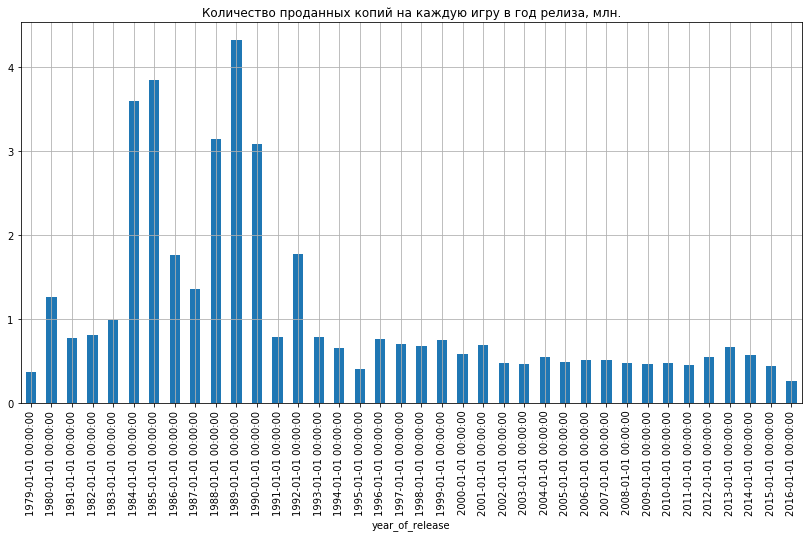

In [22]:
sales_by_year['mean_sale'].plot.bar(figsize=(14,7), grid=True)
plt.title('Количество проданных копий на каждую игру в год релиза, млн.')
plt.show()

Несмотря на повышение качества железа со временем, КПД ранних игр выше. Рынок явно требует оживления.
Однако следует отметиь, что игры качественно поменялись и, что не менее важно, продолжают меняться (качество картинки, внедрение новых технологий, например VR, привлечение звезд музыки и кино, кросс-платформа, реклама и т.д.). Из этого следует, что для нашего анализа требуются свежие данные.

### Продажи по платформам

Для начала выясняю, на какой платформе самые большие продажи и для какой платформы создано больше всего игр.

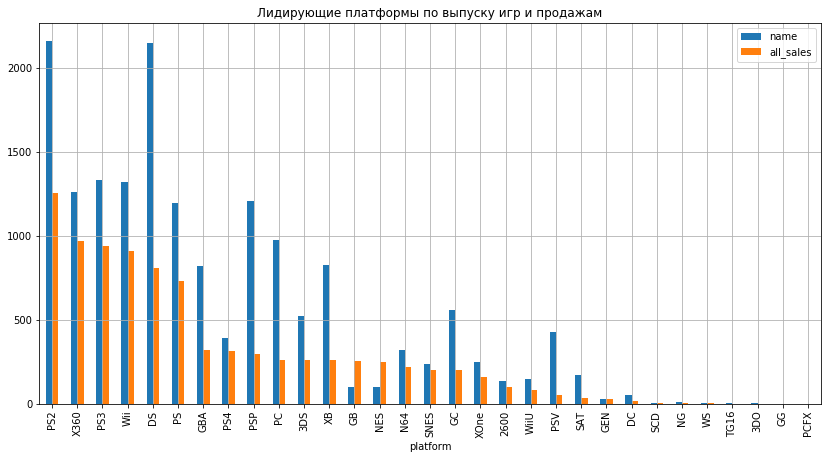

In [23]:
df.groupby('platform').agg({'name':'count', 'all_sales':'sum'}).sort_values(by='all_sales'
                                                         , ascending=False).plot.bar(figsize=(14,7), grid=True)
plt.title('Лидирующие платформы по выпуску игр и продажам')
plt.show()

Как видно из графика, абсолютный чемпион - PS2. По выпущенным играм сравнится разве что DS, а по продажам в затылок вообще никто не дышит. Вернее, не дышал, т.к. PS2 уже заменили PS3 и PS4.

Особую группу в этом списке занимает PC, так как он был, есть и будет.
Поэтому в исследование включаю 10 платформ, включая PC.

In [24]:
df.groupby('platform').agg({'name':'count', 'all_sales':'sum'}).sort_values(by='all_sales'
                                                         , ascending=False).head(10)

,name,all_sales
platform,,
PS2,2161,1255.77
X360,1262,971.42
PS3,1331,939.65
Wii,1320,907.51
DS,2151,806.12
PS,1197,730.86
GBA,822,317.85
PS4,392,314.14
PSP,1209,294.05


In [25]:
platform_list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC']

In [26]:
platform_year = df.query('platform in @platform_list')

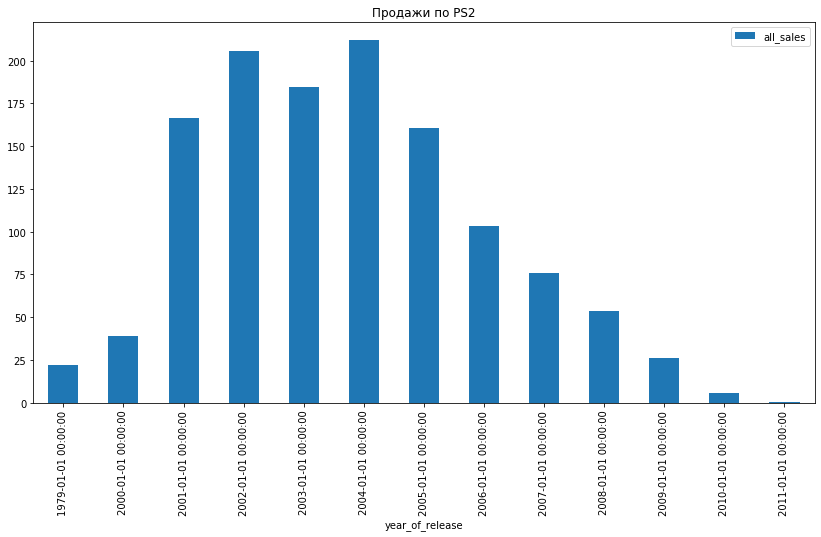

In [27]:
platform_year.query('platform in "PS2"').pivot_table(index='year_of_release', values='all_sales'
                          , aggfunc='sum').plot.bar(figsize=(14,7))
plt.title('Продажи по PS2')
plt.show()

Отчетливо прослеживается стабильный период с 2001 по 2005 гг., далее спад

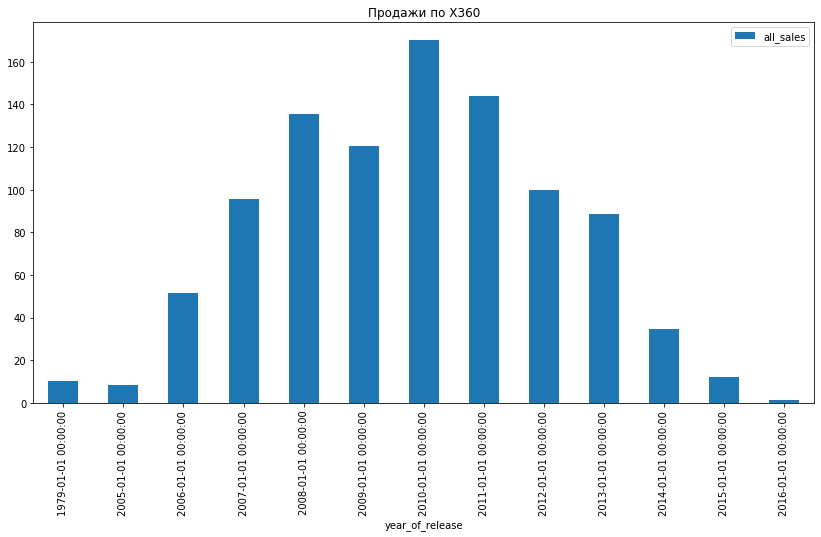

In [28]:
platform_year.query('platform in "X360"').pivot_table(index='year_of_release', values='all_sales'
                          , aggfunc='sum').plot.bar(figsize=(14,7))
plt.title('Продажи по X360')
plt.show()

Период активности шире, чем у PS2, однако пик приходится с 2008 по 2011 гг.

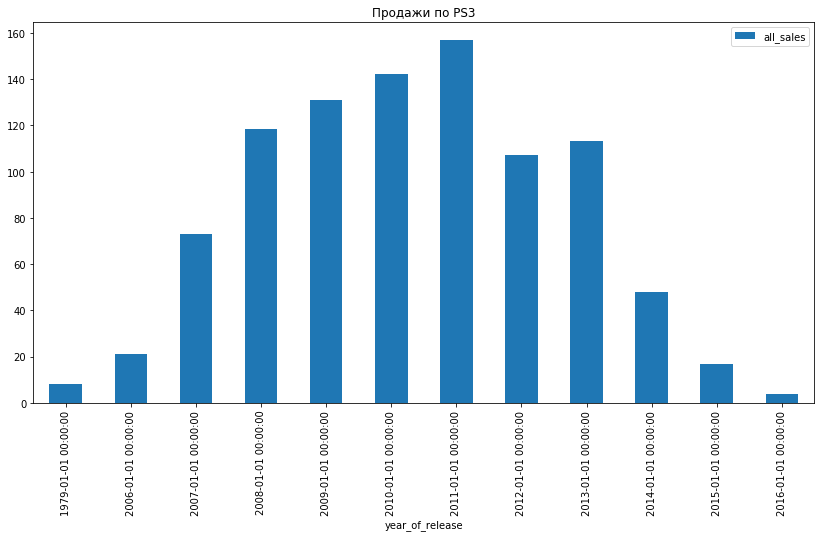

In [29]:
platform_year.query('platform in "PS3"').pivot_table(index='year_of_release', values='all_sales'
                          , aggfunc='sum').plot.bar(figsize=(14,7))
plt.title('Продажи по PS3')
plt.show()

Опять же широкий период активности с 2007 по 2013 гг., максимальные значения с 2008 по 2011 гг.

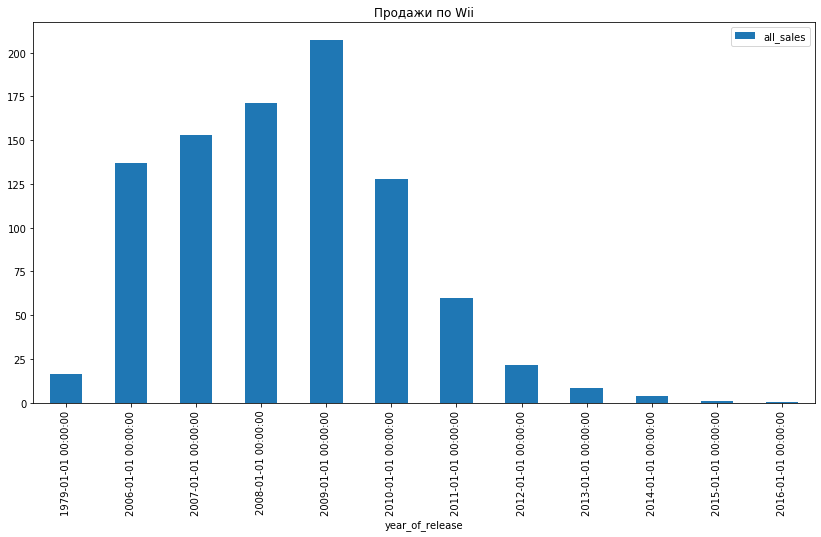

In [30]:
platform_year.query('platform in "Wii"').pivot_table(index='year_of_release', values='all_sales'
                          , aggfunc='sum').plot.bar(figsize=(14,7))
plt.title('Продажи по Wii')
plt.show()

Стремительное появление на рынке, хорошие показатели в течение 4-5 лет, далее - спад.

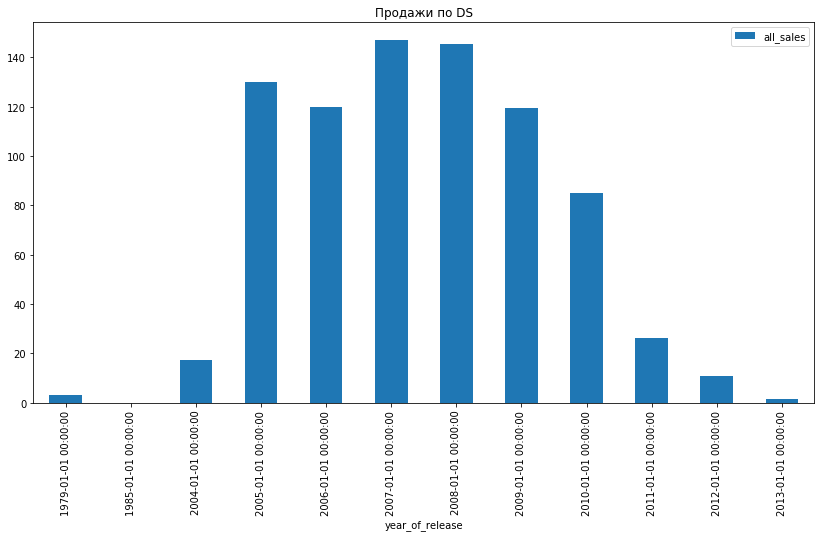

In [31]:
platform_year.query('platform in "DS"').pivot_table(index='year_of_release', values='all_sales'
                          , aggfunc='sum').plot.bar(figsize=(14,7))
plt.title('Продажи по DS')
plt.show()

Похожая картина, но период хороших продаж шире - до 6 лет

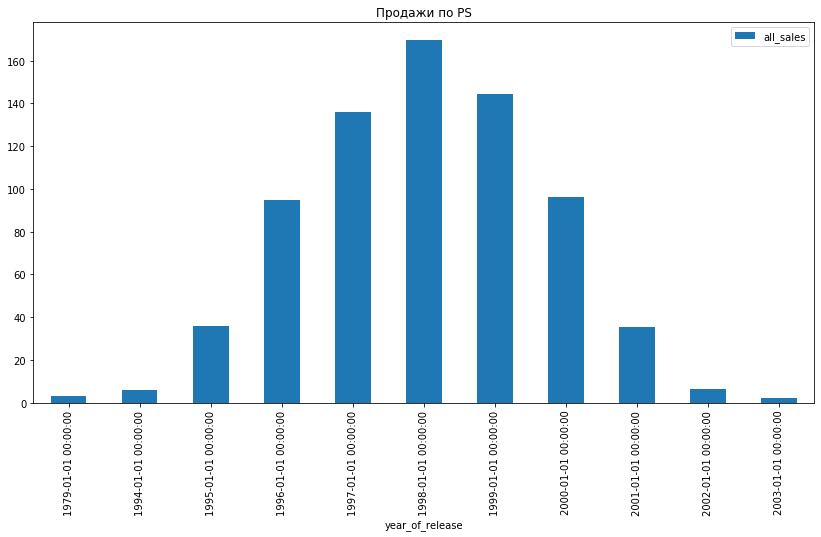

In [32]:
platform_year.query('platform in "PS"').pivot_table(index='year_of_release', values='all_sales'
                          , aggfunc='sum').plot.bar(figsize=(14,7))
plt.title('Продажи по PS')
plt.show()

Распределение плавное, но тенденция в 5 лет прослеживается

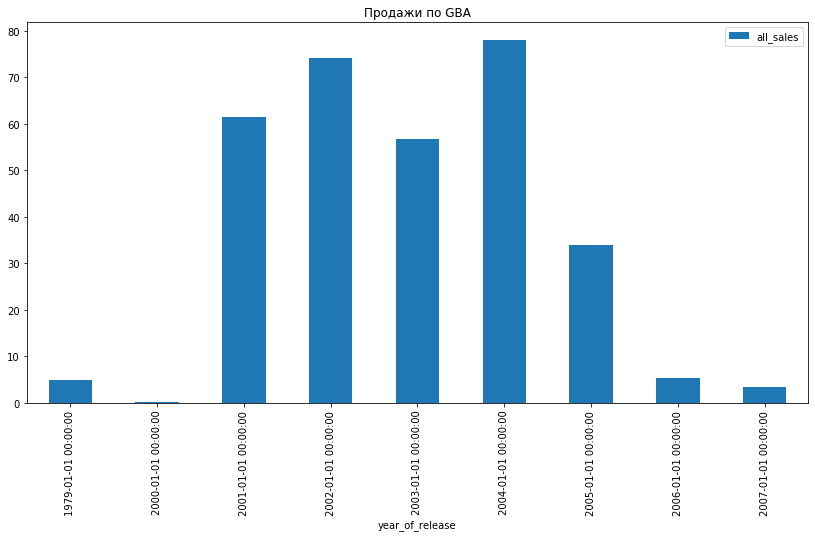

In [33]:
platform_year.query('platform in "GBA"').pivot_table(index='year_of_release', values='all_sales'
                          , aggfunc='sum').plot.bar(figsize=(14,7))
plt.title('Продажи по GBA')
plt.show()

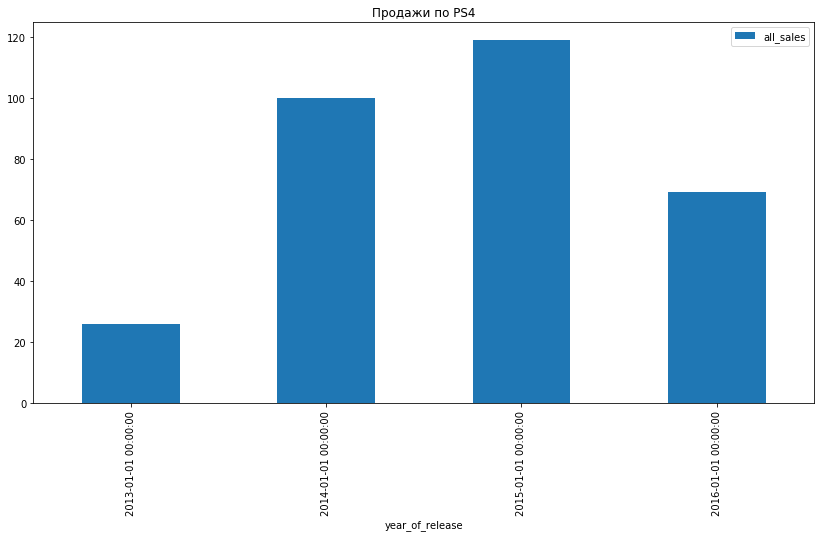

In [34]:
platform_year.query('platform in "PS4"').pivot_table(index='year_of_release', values='all_sales'
                          , aggfunc='sum').plot.bar(figsize=(14,7))
plt.title('Продажи по PS4')
plt.show()

Период наблюдения мал, но нехарактерное снижение всего лишь через 2 хороших года

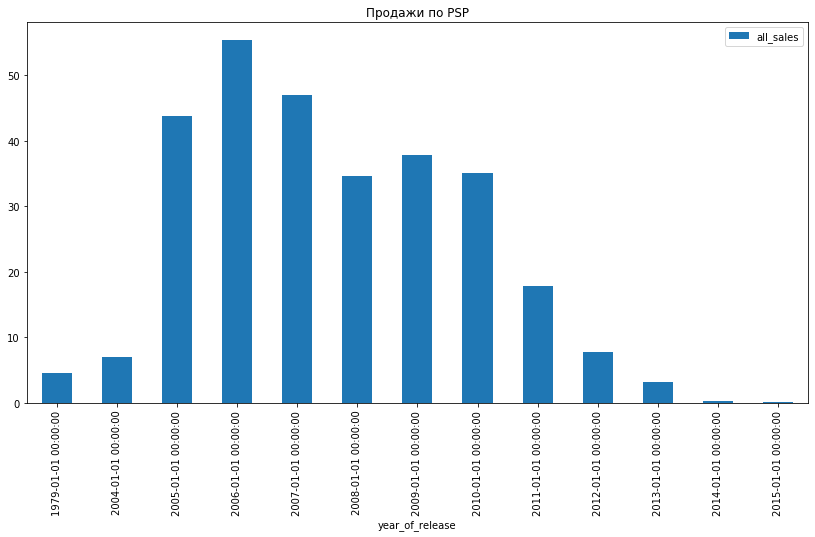

In [35]:
platform_year.query('platform in "PSP"').pivot_table(index='year_of_release', values='all_sales'
                          , aggfunc='sum').plot.bar(figsize=(14,7))
plt.title('Продажи по PSP')
plt.show()

6 хороших уверенных года, видимо конкуренты догнать не могли долго

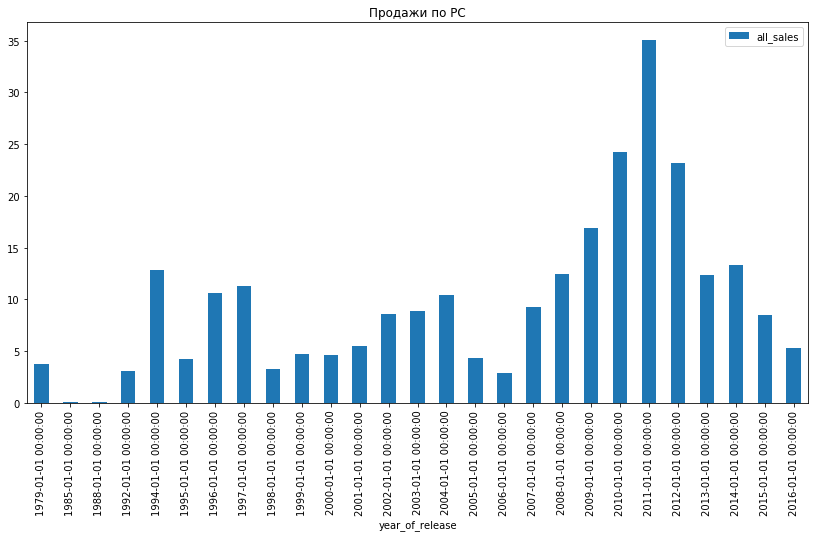

In [36]:
platform_year.query('platform in "PC"').pivot_table(index='year_of_release', values='all_sales'
                          , aggfunc='sum').plot.bar(figsize=(14,7))
plt.title('Продажи по PC')
plt.show()

А здесь волны, в принципе, как и ожидалось. 2011 г. крайне удачный, но не такой удачный, как у PS3 и X360.

Резюмируя, средний успешный срок жизни топовых платформ - около 4-5 лет, в исключительных случаях, чуть больше, например PSP.

### Выделение актуального периода

Т.к. срок жизни достигает 6 лет, актуальный период установлю 3 года, чтобы в срез не попали успешные, но уже отжившие платформы.

In [37]:
actual = df.query('year_of_release >= "2014" & platform in ["PC", "XOne", "3DS", "PS4"]').copy()

In [38]:
actual

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
31,Call of Duty: Black Ops 3,PS4,2015-01-01,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,out_rang,14.63
42,Grand Theft Auto V,PS4,2014-01-01,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014-01-01,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,out_rang,11.68
77,FIFA 16,PS4,2015-01-01,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015-01-01,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,out_rang,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16660,Prison Architect,XOne,2016-01-01,Action,0.01,0.00,0.00,0.00,74.0,6.7,out_rang,0.01
16668,Fujiko F. Fujio Characters: Great Assembly! Sl...,3DS,2014-01-01,Action,0.00,0.00,0.01,0.00,NaN,NaN,out_rang,0.01
16672,Metal Gear Solid V: The Definitive Experience,XOne,2016-01-01,Action,0.01,0.00,0.00,0.00,NaN,NaN,M,0.01
16677,Aikatsu Stars! My Special Appeal,3DS,2016-01-01,Action,0.00,0.00,0.01,0.00,NaN,NaN,out_rang,0.01


### Лидирующие платформы

Сгруппирую данные по году и платформе, посчитаю суммарные продажи.

In [39]:
actual_sort = actual.pivot_table(index=['year_of_release', 'platform']
                   , values='all_sales'
                   , aggfunc='sum').sort_values(by=['year_of_release', 'all_sales'], ascending=False).reset_index()

In [40]:
actual_sort.head(10)

,year_of_release,platform,all_sales
0,2016-01-01,PS4,69.25
1,2016-01-01,XOne,26.15
2,2016-01-01,3DS,15.14
3,2016-01-01,PC,5.25
4,2015-01-01,PS4,118.90
5,2015-01-01,XOne,60.14
6,2015-01-01,3DS,27.78
7,2015-01-01,PC,8.52
8,2014-01-01,PS4,100.00
9,2014-01-01,XOne,54.07


Итак, посмотрим на 2016 год, 3 платформы четко определяют продажи, выбиваясь далеко вперед от остальных: PS4, XOne и 3DS.
Учитывая специфику PC, рассмотрю и эту группу.

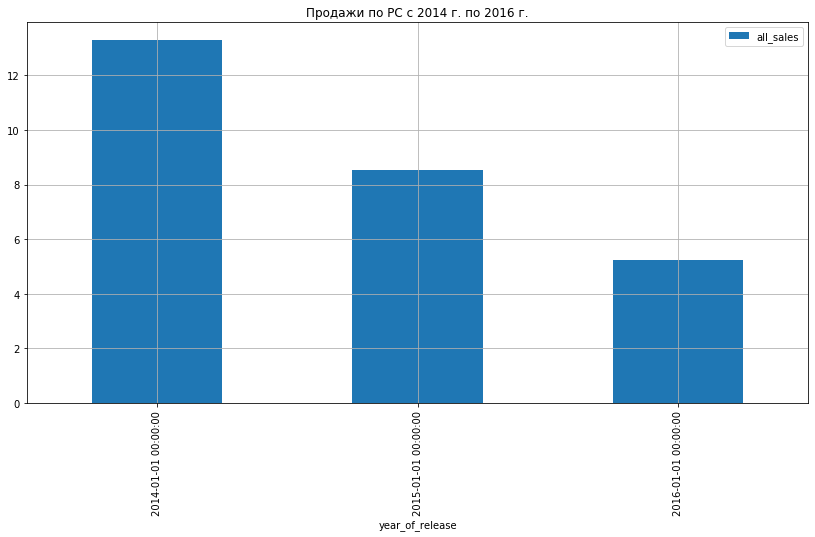

In [41]:
actual_sort.query('platform in "PC"').sort_values(by='year_of_release').plot.bar(x='year_of_release'
                                                                                 , y='all_sales',figsize=(14,7)
                                                                                ,grid=True)
plt.title('Продажи по PC с 2014 г. по 2016 г.')
plt.show()

Комментарии излишни. Явное снижение.

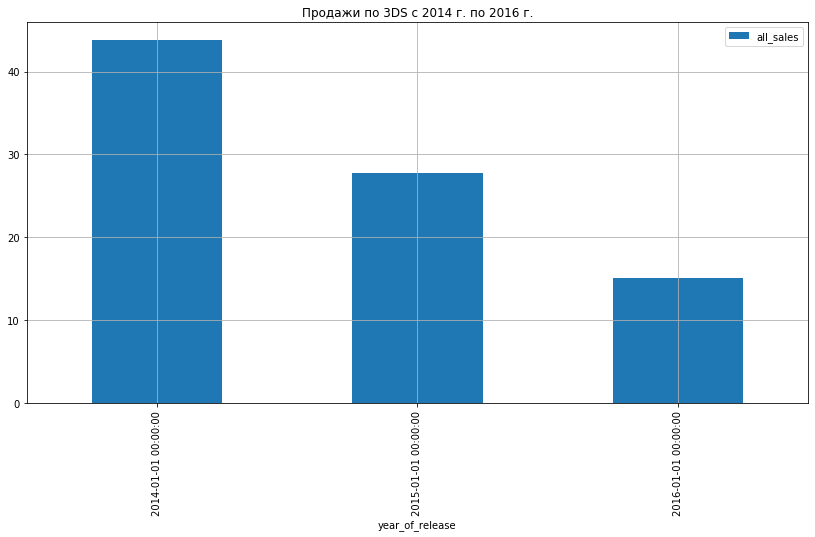

In [42]:
actual_sort.query('platform in "3DS"').sort_values(by='year_of_release').plot.bar(x='year_of_release'
                                                                                 , y='all_sales',figsize=(14,7)
                                                                                 ,grid=True)
plt.title('Продажи по 3DS с 2014 г. по 2016 г.')
plt.show()

Такая же история - стойкое снижение.

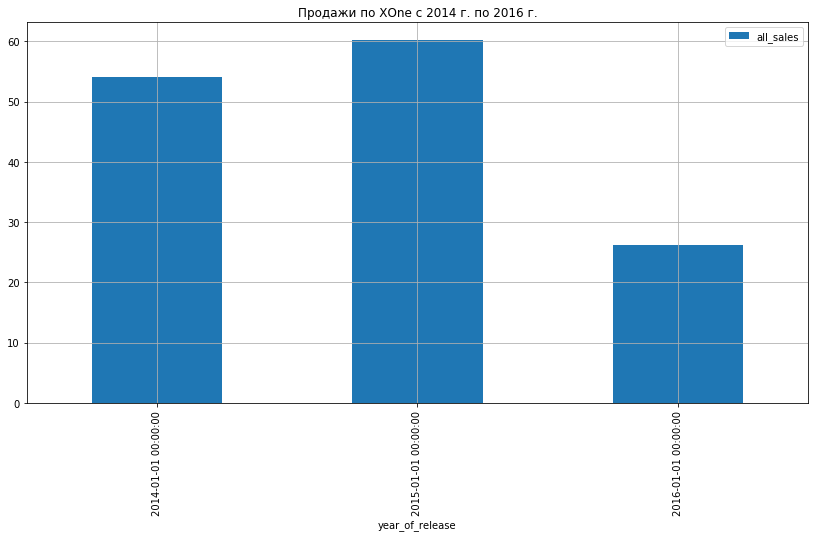

In [43]:
actual_sort.query('platform in "XOne"').sort_values(by='year_of_release').plot.bar(x='year_of_release'
                                                                                 , y='all_sales',figsize=(14,7)
                                                                                   ,grid=True)
plt.title('Продажи по XOne с 2014 г. по 2016 г.')
plt.show()

У XOne рост до 2015 г., а затем, в 2016 г., сокращение продаж больше, чем в 2 раза.

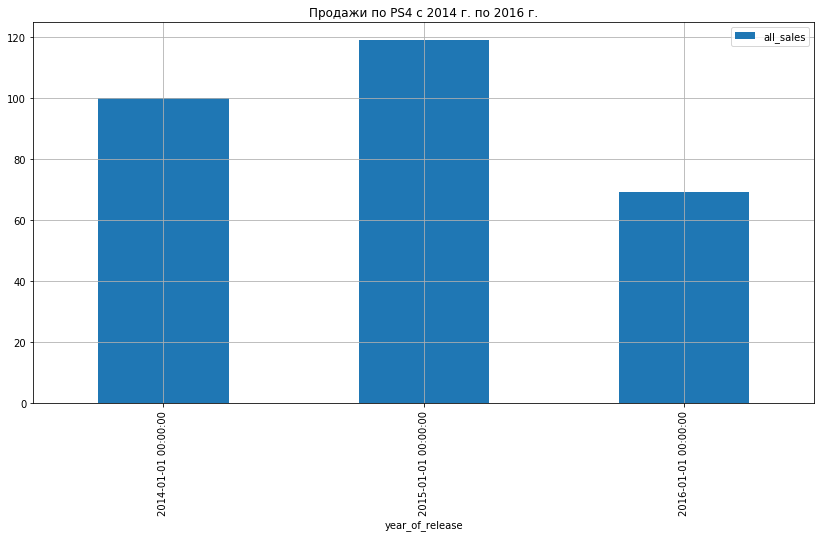

In [44]:
actual_sort.query('platform in "PS4"').sort_values(by='year_of_release').plot.bar(x='year_of_release'
                                                                                 , y='all_sales',figsize=(14,7)
                                                                                   ,grid=True)
plt.title('Продажи по PS4 с 2014 г. по 2016 г.')
plt.show()

Подведем итог: у ВСЕХ рассматриваемых платформ отмечается снижение продаж. Не так плохо выглядит PS4, но всё же.
Возникает ощущение, что мы ждем новых платформ.
Отмечу, что пользователи PC находятся в более выгодной позиции, по стравнению с пользователями консолей, так как они сами выбирают на чем и в каком качестве им играть, тогда как пользователь консоли зависит от производителя, который "диктует", на чем и во что играть.

### Boxplot

In [45]:
actual.sample()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16585,Farming 2017 - The Simulation,PS4,2016-01-01,Simulation,0.0,0.01,0.0,0.0,NaN,NaN,out_rang,0.01


In [46]:
actual_box = actual[['platform', 'all_sales']]

In [47]:
actual_box.groupby('platform')['all_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PC,151.0,0.179139,0.329359,0.01,0.0200,0.060,0.2000,3.05
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
XOne,228.0,0.615614,1.046513,0.01,0.0500,0.205,0.6325,7.39


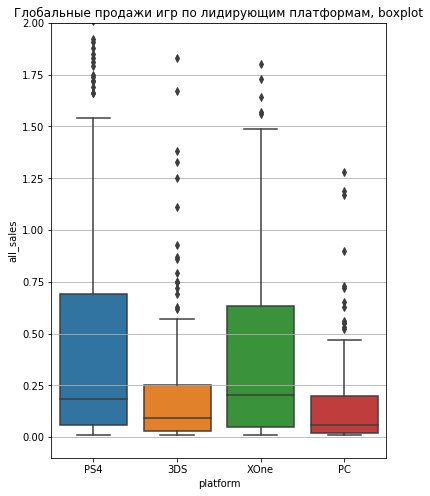

In [48]:
plt.figure(figsize=(6,8))
plt.ylim(-0.1, 2)
plt.grid()
plt.title('Глобальные продажи игр по лидирующим платформам, boxplot')
ax = sns.boxplot(x='platform', y='all_sales', data=actual_box)

Ящики с усами PS4 и XOne очень похожи, как и 3DS c PC. Очень много выбросов в группе PS4 и XOne, немного меньше в 3DS. В группе PC выбросы единичные. У всех отмечается скошенность вправо, ящики расположены очень близко к нулю, как говорится "всё или ничего". У корпораций игровых консолей дела обстоят лучше, чем у PC.

### Зависимость продаж от отзывов 

In [49]:
user_corr = actual.loc[~actual['user_score'].isna() & ~actual['critic_score'].isna(), ['platform'
                                                                                       ,'user_score'
                                                                                       , 'critic_score'
                                                                                       , 'all_sales']]

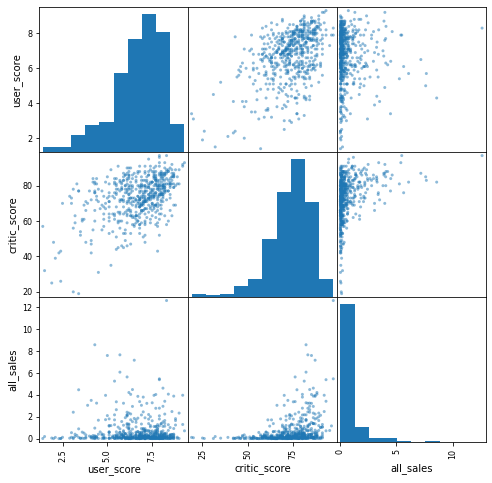

In [50]:
pd.plotting.scatter_matrix(user_corr, figsize=(8, 8));

In [51]:
user_corr.corr()

,user_score,critic_score,all_sales
user_score,1.000000,0.477567,-0.013407
critic_score,0.477567,1.000000,0.327615
all_sales,-0.013407,0.327615,1.000000


In [52]:
user_corr.corr()

,user_score,critic_score,all_sales
user_score,1.000000,0.477567,-0.013407
critic_score,0.477567,1.000000,0.327615
all_sales,-0.013407,0.327615,1.000000


Как видно, наибольшая взаимосвязь отмечается между отзывами критиков и пользователей, логично, хотя и составляет всего 0,5.
Ну и отзывы критиков больше влияют на продажи, хотя.. может быть и наоборот.

#### PC

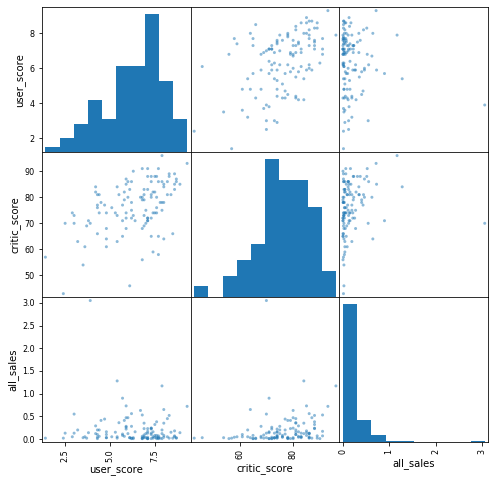

In [53]:
pc_corr = user_corr.query('platform in "PC"')
pd.plotting.scatter_matrix(pc_corr, figsize=(8, 8));

In [54]:
pc_corr.corr()

,user_score,critic_score,all_sales
user_score,1.000000,0.466099,-0.089974
critic_score,0.466099,1.000000,0.172061
all_sales,-0.089974,0.172061,1.000000


Зависимость продаж от отзывов пользователей практически отсутствует, от отзывов критиков коэффицент всего 0,17.

#### 3DS

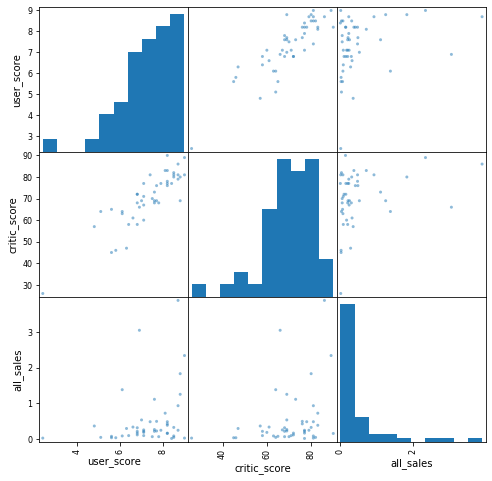

In [55]:
ds3_corr = user_corr.query('platform in "3DS"')
pd.plotting.scatter_matrix(ds3_corr, figsize=(8, 8));

In [56]:
ds3_corr.corr()

,user_score,critic_score,all_sales
user_score,1.000000,0.862485,0.279850
critic_score,0.862485,1.000000,0.284686
all_sales,0.279850,0.284686,1.000000


Зависимость между отзывами аж 0,86. Продажи практически одинаково коррелируют с отзывами от критиков и пользователей - почти 0,3.

#### XOne

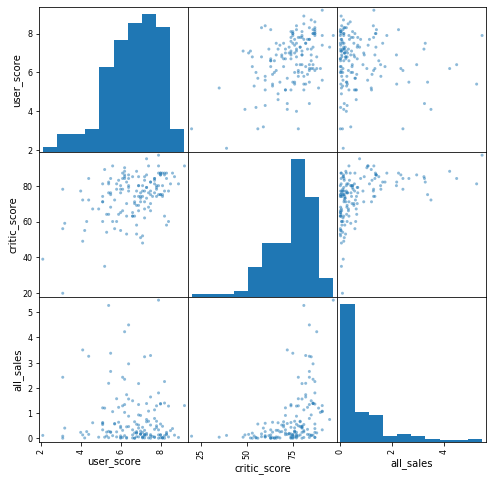

In [57]:
xone_corr = user_corr.query('platform in "XOne"')
pd.plotting.scatter_matrix(xone_corr, figsize=(8, 8));

In [58]:
xone_corr.corr()

,user_score,critic_score,all_sales
user_score,1.000000,0.440977,-0.091734
critic_score,0.440977,1.000000,0.422112
all_sales,-0.091734,0.422112,1.000000


Корреляция между отзывами 0,44. Между отзывами критиков и продажами - 0,42. Отзывы пользователей с продажами коррелируют незначительно.

#### PS4

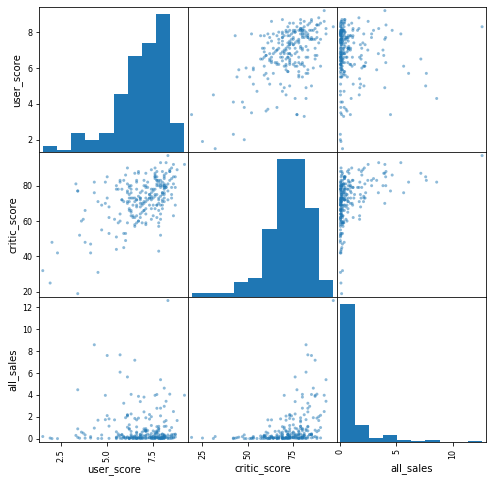

In [59]:
ps4_corr = user_corr.query('platform in "PS4"')
pd.plotting.scatter_matrix(ps4_corr, figsize=(8, 8));

In [60]:
ps4_corr.corr()

,user_score,critic_score,all_sales
user_score,1.000000,0.546434,-0.043186
critic_score,0.546434,1.000000,0.401903
all_sales,-0.043186,0.401903,1.000000


Корреляция между отзывами 0,54. Между отзывами критиков и продажами - 0,40. Отзывы пользователей с продажами также коррелируют незначительно.

Для того, чтобы продать продукт, нужно пошуметь. Отзывы критиков (которые, кстати, имеют доступ к игре раньше пользователей) однозначно подогревают интрес. Медиапространство в последнее время необъятно, получать интерисующую информацию можно из десятков источников (NB! на консолях реклама уже встроена), возможно, поэтому коэффициент только 0,17 на PC и 0,42 на XOne.

### Зависимость продаж от жанра игры

In [61]:
genre_sales = actual.pivot_table(index='genre', values='all_sales', aggfunc=('sum', 'mean', 'median')).reset_index()

In [62]:
genre_sales.sort_values(by='median', ascending=False)

,genre,mean,median,sum
8,Shooter,1.469895,0.550,139.64
10,Sports,0.825435,0.240,75.94
7,Role-Playing,0.680887,0.190,84.43
4,Platform,0.458182,0.155,10.08
2,Fighting,0.624138,0.150,18.10
0,Action,0.430029,0.110,150.08
9,Simulation,0.331892,0.110,12.28
6,Racing,0.361020,0.100,17.69
3,Misc,0.312034,0.090,18.41
5,Puzzle,0.111250,0.065,0.89


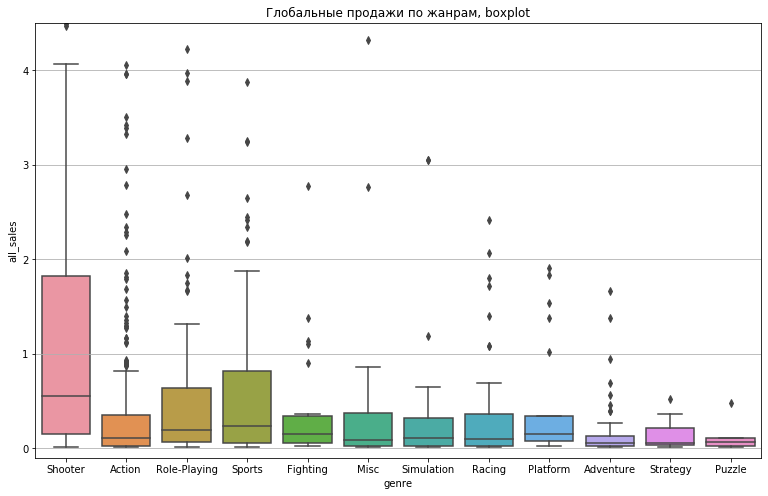

In [63]:
plt.figure(figsize=(13,8))
plt.ylim(-0.1, 4.5)
plt.grid()
plt.title('Глобальные продажи по жанрам, boxplot')
ax = sns.boxplot(x='genre', y='all_sales', data=actual)

Итак, определилась тройка лидирующих жанров: Shooter(!!!), Sports и Role-Playing. Явно горожанам не хватает физической активности. И сказки...
В жанре Action наибольшее количество выбросов, игры с жанром puzzle пользуются наименьшей популярностью.

## Портрет пользователя по региону

In [64]:
portrait = actual.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'
                                                        , 'all_sales'], aggfunc='sum').reset_index()

### NA

#### Популярные платформы

Определим долю продаж.

In [65]:
portrait['part_sales_na'] = portrait['na_sales'] / portrait['all_sales']*100

In [66]:
portrait.sort_values(by='na_sales', ascending=False).head()

,platform,all_sales,eu_sales,jp_sales,na_sales,part_sales_na
2,PS4,288.15,130.04,15.02,98.61,34.221760
3,XOne,140.36,46.25,0.32,81.27,57.901111
0,3DS,86.68,16.12,44.24,22.64,26.119059
1,PC,27.05,17.97,0.00,7.23,26.728281


Неожиданно, но в Североамериканском регионе лидирует Япония - 98,61 млн. копий игр, что составляет 34% от мировых продаж.
Далее следует XOne - 81,27 млн. копий и 57,9%!!! мирового рынка. Третье место - X360: 28,3 млн.копий и 58% мирового рынка.
Четвертое место - 3DS: 22,6 млн. копий, 26% мирового рынка. И завершает рейтинг PS3: 22 млн.копий игр, 32% мирового рынка.

Надо разобраться. Фактически, у Sony 120 млн. копий, далее Microsoft c 109 млн. копий и Nintendo c 22,6 млн. копий.
Если разбивать по странам, то в Северной Америке пользователи используют японские консоли на 40% больше, чем USA-вские (может, Канада постаралась).

#### Популярные жанры

In [67]:
portrait_genre = actual.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'
                                                        , 'all_sales'], aggfunc='sum').reset_index()

In [68]:
portrait_genre.sort_values(by='na_sales', ascending=False).head()

,genre,all_sales,eu_sales,jp_sales,na_sales
8,Shooter,139.64,54.79,2.67,64.24
0,Action,150.08,58.59,19.12,54.59
10,Sports,75.94,32.78,1.44,31.49
7,Role-Playing,84.43,24.97,23.75,28.49
2,Fighting,18.10,4.60,3.57,8.04


Наиболее популярны в Северной Америке: Shooter, Action, Sports, Role-Playing, Misc.

#### Рейтинг ESRB

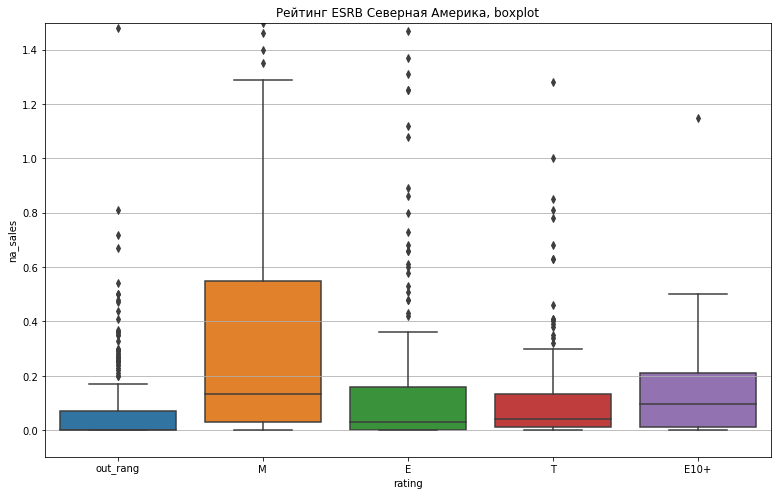

In [69]:
plt.figure(figsize=(13,8))
plt.ylim(-0.1, 1.5)
plt.grid()
plt.title('Рейтинг ESRB Северная Америка, boxplot')
ax = sns.boxplot(x='rating', y='na_sales', data=actual)

На первом месте игры для взрослых (ожидаемо), далее игры для всех от 10 лет, третью позицию занимают игры для всех, затем игры для подростков и на последнем месте  игры без обозначенного рейтинга.

### EU

#### Популярные платформы

Определим процент продаж.

In [70]:
portrait['part_sales_eu'] = portrait['eu_sales'] / portrait['all_sales']*100

In [71]:
portrait.sort_values(by='eu_sales', ascending=False).head()

,platform,all_sales,eu_sales,jp_sales,na_sales,part_sales_na,part_sales_eu
2,PS4,288.15,130.04,15.02,98.61,34.221760,45.129273
3,XOne,140.36,46.25,0.32,81.27,57.901111,32.950983
1,PC,27.05,17.97,0.00,7.23,26.728281,66.432532
0,3DS,86.68,16.12,44.24,22.64,26.119059,18.597139


На европейском рынке X360 заменили игры на PC, в итоге: 1 место - Sony (PS4 130 млн.копий и 45% рынка, PS3 25,5 млн.копий и 37% рынка); 2 место - XOne 46,25 млн.копий, 33% рынка; 3 место - PC почти 18 млн.копий и 66,4% мирового рынка; 4 место - 3DS с 16 млн.копий и 18,5% мирового рынка.

#### Популярные жанры

In [72]:
portrait_genre.sort_values(by='eu_sales', ascending=False).head()

,genre,all_sales,eu_sales,jp_sales,na_sales
0,Action,150.08,58.59,19.12,54.59
8,Shooter,139.64,54.79,2.67,64.24
10,Sports,75.94,32.78,1.44,31.49
7,Role-Playing,84.43,24.97,23.75,28.49
6,Racing,17.69,10.76,0.27,4.57


Наиболее популярны в Европе: Action, Shooter, Sports, Role-Playing, Racing.

#### Рейтинг ESRB

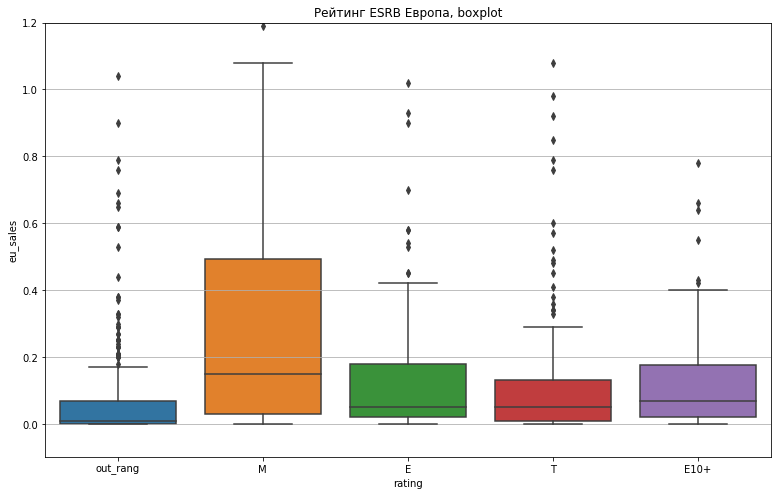

In [73]:
plt.figure(figsize=(13,8))
plt.ylim(-0.1, 1.2)
plt.grid()
plt.title('Рейтинг ESRB Европа, boxplot')
ax = sns.boxplot(x='rating', y='eu_sales', data=actual)

На первом месте игры для взрослых (ожидаемо), далее игры для всех, затем игры для всех от 10 лет и игры для подростков, и на последнем месте игры без рейтигна. В отличие от североамериканского рынка, Е и Е10+ поменялись местами.

### JP

#### Популярные платформы

Определим процент продаж.

In [74]:
portrait['part_sales_jp'] = portrait['jp_sales'] / portrait['all_sales']*100

In [75]:
portrait.sort_values(by='jp_sales', ascending=False).head()

,platform,all_sales,eu_sales,jp_sales,na_sales,part_sales_na,part_sales_eu,part_sales_jp
0,3DS,86.68,16.12,44.24,22.64,26.119059,18.597139,51.038302
2,PS4,288.15,130.04,15.02,98.61,34.221760,45.129273,5.212563
3,XOne,140.36,46.25,0.32,81.27,57.901111,32.950983,0.227985
1,PC,27.05,17.97,0.00,7.23,26.728281,66.432532,0.000000


На японском рынке все рейтинговые строчки захватили сами японцы, в итоге: 1 место - 3DS 44 млн.копий и 51% мирового рынка; 2 место - PS4 15 млн.копий, 5% рынка, очень неожиданно; 3 место - PSV 14,5 млн.копий и 64,9% мирового рынка; 4 место - PS3 11 млн.копий и 16,4% мирового рынка; 5 место - WiiU 7,3 млн. копий и 17% мирового рынка.

#### Популярные жанры

In [76]:
portrait_genre.sort_values(by='jp_sales', ascending=False).head()

,genre,all_sales,eu_sales,jp_sales,na_sales
7,Role-Playing,84.43,24.97,23.75,28.49
0,Action,150.08,58.59,19.12,54.59
2,Fighting,18.10,4.60,3.57,8.04
8,Shooter,139.64,54.79,2.67,64.24
3,Misc,18.41,6.14,2.48,7.86


Наиболее популярны в Европе: Role-Playing, Action, Fighting, Misc., Shooter.

#### Рейтинг ESRB

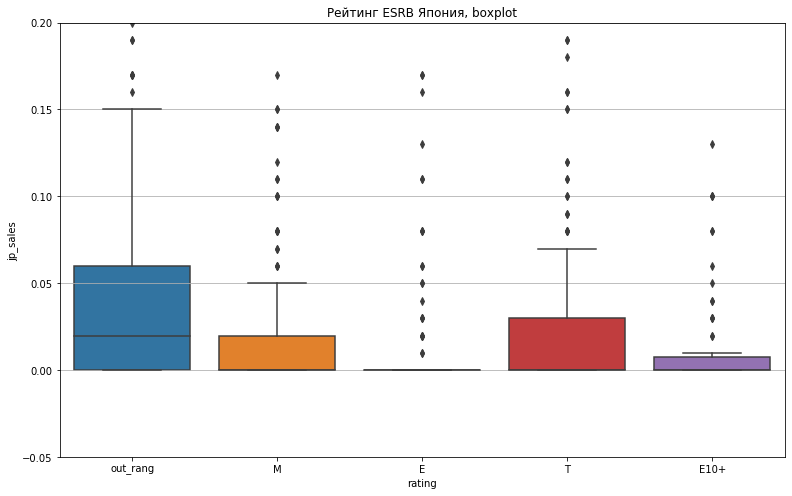

In [77]:
plt.figure(figsize=(13,8))
plt.ylim(-0.05, 0.2)
plt.grid()
plt.title('Рейтинг ESRB Япония, boxplot')
ax = sns.boxplot(x='rating', y='jp_sales', data=actual)

С рейтингом ESRB в Японии явные проблемы, все ящики лежат на нуле, значения урезаны в разы по сравнению с западными рынками.
На первом месте игры без рейтинга, на втором игры для подростков, далее игры для взрослых и игры для всех от 10 лет и на последнем месте игры для всех.
Видимо японские пользователи в основной своей массе - это подростки, играющие на портативных платформах, большей частью, в родные японские игры, не предназначенные для экспорта.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H₀ - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H₁ - Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

Гипотеза двусторонняя, определяю alpha=0.05.

Для определения тактики вычисления смотрю на дисперсию (генеральная совокупность)

In [78]:
alpha = 0.05

In [79]:
h_xone = actual.loc[~(actual['user_score'].isna()) & (actual['platform'] == 'XOne')]['user_score'].copy()
h_pc = actual.loc[~(actual['user_score'].isna()) & (actual['platform'] == 'PC')]['user_score'].copy()

In [80]:
print('Дисперсия XOne: ', (np.var(h_xone)))
print('Дисперсия PC: ', (np.var(h_pc)))
print('Выборка XOne: ', len(h_xone))
print('Выборка PC: ', len(h_pc))
print('Среднее XOne: ', h_xone.mean())
print('Среднее PC: ', h_pc.mean())

Дисперсия XOne:  1.8795460055096425
Дисперсия PC:  2.8773743617307175
Выборка XOne:  165
Выборка PC:  122
Среднее XOne:  6.594545454545456
Среднее PC:  6.298360655737705


Дисперсия практически отличается незначительно, поэтому буду использовать equal_var=True. Учитывая, что гипотеза о равенстве двух выборок, использую st.ttest_ind.

In [81]:
result = st.ttest_ind(h_xone, h_pc, equal_var = True)
print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу.


Средние пользовательские рейтинги равны.

### Средние пользовательские рейтинги жанров Action и Sports разные

H₀ - Средние пользовательские рейтинги жанров Action и Sports равны.

H₁ - Средние пользовательские рейтинги жанров Action и Sports разные.

Гипотеза двусторонняя, определяю alpha=0.05.

Для определения тактики вычисления смотрю на дисперсию (генеральная совокупность).

In [82]:
h_action = actual.loc[ ~(actual['user_score'].isna()) & (actual['genre'] == 'Action')]['user_score'].copy()
h_sports = actual.loc[ ~(actual['user_score'].isna()) & (actual['genre'] == 'Sports')]['user_score'].copy()

In [83]:
print('Дисперсия Action: ', (np.var(h_action)))
print('Дисперсия Sports: ', (np.var(h_sports)))
print('Выборка Action: ', len(h_action))
print('Выборка Sports: ', len(h_sports))
print('Среднее Action: ', h_action.mean())
print('Среднее Sports: ', h_sports.mean())

Дисперсия Action:  1.797270963970666
Дисперсия Sports:  2.519134278311233
Выборка Action:  194
Выборка Sports:  81
Среднее Action:  6.730412371134021
Среднее Sports:  5.598765432098766


Дисперсия практически не отличается, поэтому буду использовать equal_var=True. Учитывая, что гипотеза о равенстве двух неравных выборок, использую st.ttest_ind.

In [84]:
result = st.ttest_ind(h_action, h_sports, equal_var = True)
print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 5.856201190470744e-09
Отвергаем нулевую гипотезу.


Средние пользовательские рейтинги жанров Action и Sports разные. Выше было выяснено, что жанр Sports входит в топ-3 на западных рынках, а вот action искусственно раздут.

## Вывод

Целью исследования было выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
По данным проведенного исследования выяснилось:
- успешные платформы (за исключением PC) "живут" 4-5 лет;
- растущих платформ не выявлено, но наиболее интересно выглядят PS4 и XOne (причем Microsoft славится созданием консолей-приемников, практически все игры с обратной совместимостью);
- популярность игры зависит от жанра (Top-3: Shooter, Sports и Role-Playing; не стоит забывать и про Action, некоторые экземпляры здорово продаются);
- региона продаж (в азиатском регионе пользователи больше, чем в других регионах, используют носимые платформы, а на первом месте по продажам игр с рейтингом - игры для подростков).

Резюмируя, для планирования тактики закупок игр на следующий год следует придерживаться следующей тактики: следить за релизами новых платформ, сделать акцент на игры популярных жанров, но не забывать следить за релизами игр и критиками. И обязательно при планировании делать акцент на географию.